In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 生成实验时间序列
- 有总体的趋势，同时一定的周期性

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

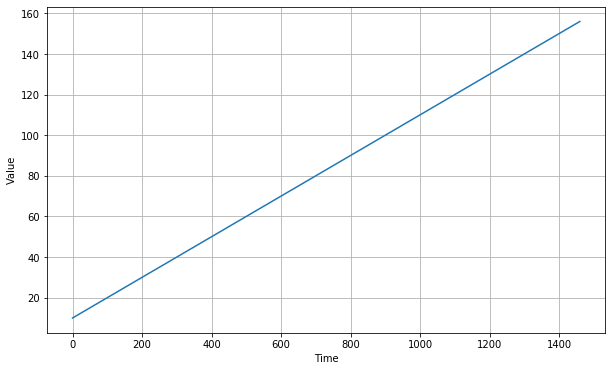

In [3]:
# 生成总体趋势，四年长度的时间序列 4*365

def trend(time, slope=0):
    return slope * time

time = np.arange(4 * 365 +1)
baseline = 10
series = baseline + trend(time, 0.1)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [5]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

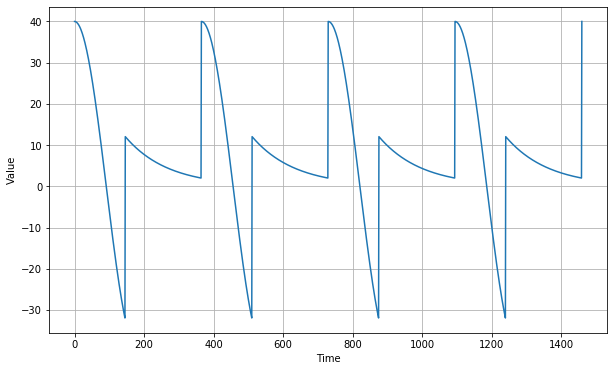

In [6]:
# 生成周期性，一年一周期，同时每年分成四个季节

def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time),
    )


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

amplitude = 40
patt = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, patt)
plt.show()

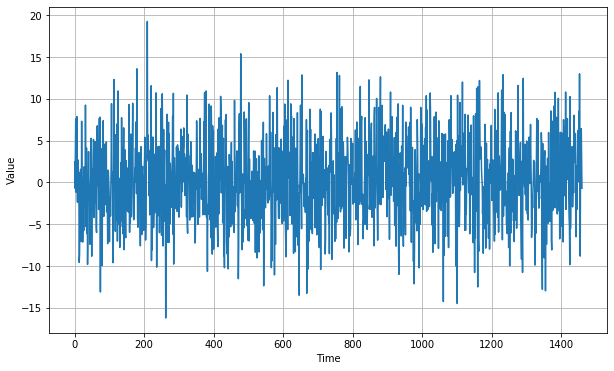

In [7]:
# 生成噪声


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

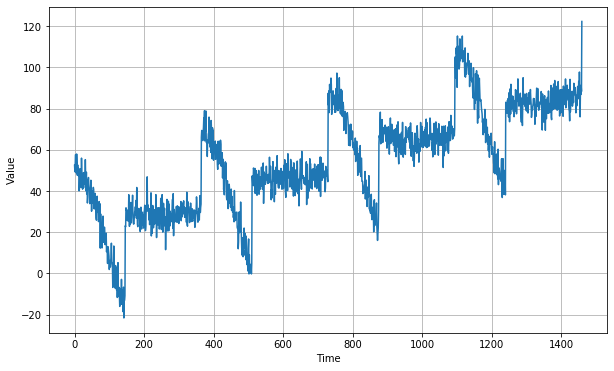

In [8]:
# 生成的时间序列

series = baseline + trend(time, 0.05) + patt + noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# 预测：
- 最简单的为`Naive Forecasting`：预测下一值等于当前序列的最后值；可最为基准模型


# 评估性能，需要拆分数据集：
- `Fixed Partitioning`：
    - 按照时间远近依次拆分成，训练集+验证集+测试集；
    - 当时间序列有周期时，拆分时不要把同一个周期的数据拆分到不同的数据集中；
    - 设置超参数来拆分数据集，通过模型的结果来获得最优的超参数对应的拆分集
    - 最后基于最优超参和拆分集，再训练一次，获得最终模型
    - 与普通模型不同，时间序列的最近时间数据通常包含最多信息，在测试集上也进行训练
    - 因此可以不设置测试集，以未来的数据作为测试
- `Roll-Forward Partitioning`：基于当前时间之前的所有数据，依次预测下一个数据

## `Naive Forecast`

In [9]:
# 拆分数据集

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
# 

naive_forecast = series[split_time - 1:-1]

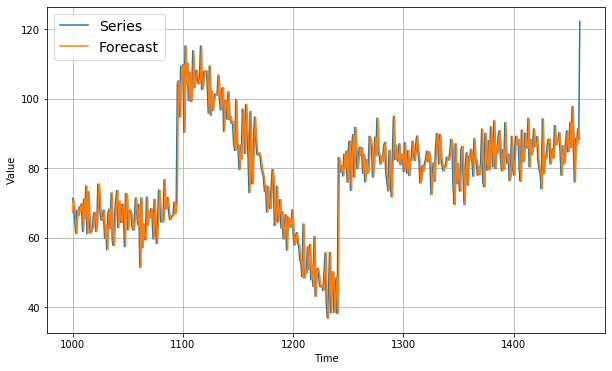

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

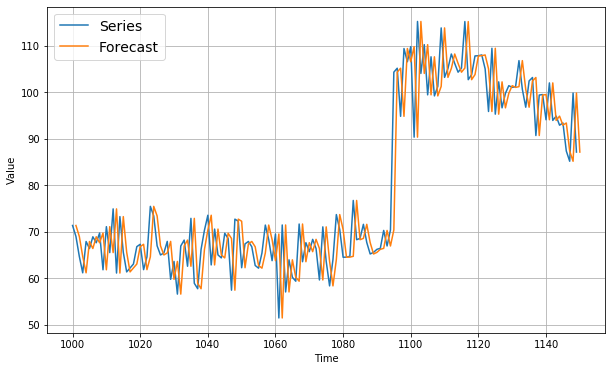

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

# 评估指标`mae`

In [13]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.9379085153216735

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

# 评估指标`MovingAverage`

In [16]:
# def moving_average_forecast(series, window_size):
#     forcast = []
#     for time in range(len(series) - window_size):
#         forecast.append(series[time:time + window].mean())
#     return np.array(forecast)


def moving_average_forecast(series, window_size):
    """
    预测值为过去一段时间值的平均值
    """
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size

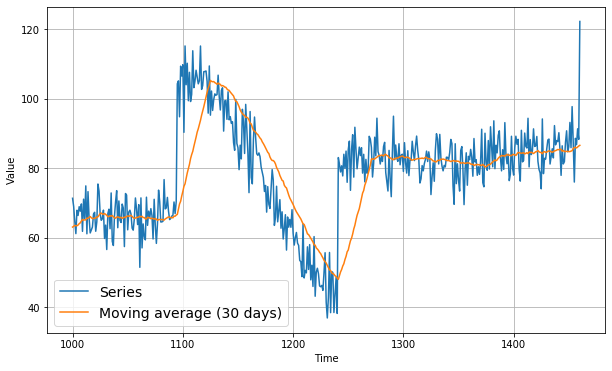

In [17]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

- `MovingAverage`比`naive forecast`的平均绝对误差更大
- 没有考虑到数据以365为周期

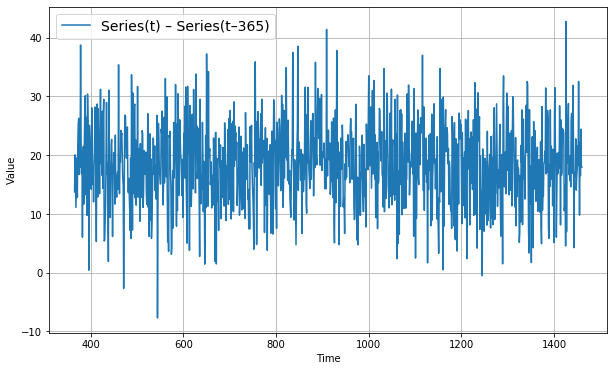

In [20]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

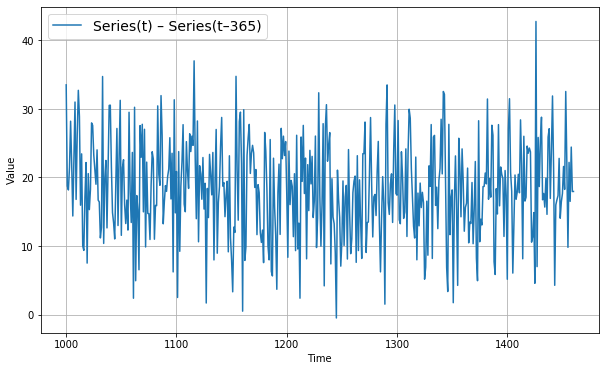

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid,
            diff_series[split_time - 365:],
            label="Series(t) – Series(t–365)")
plt.show()

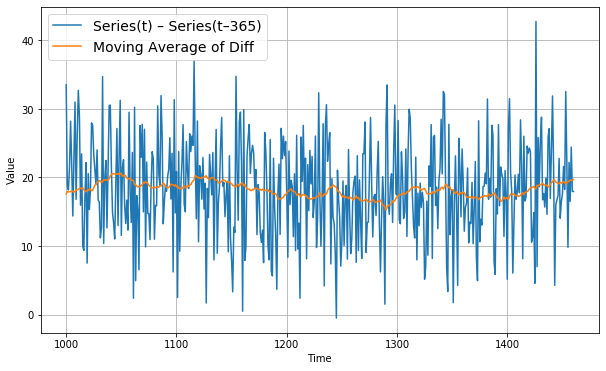

In [23]:
diff_moving_avg = moving_average_forecast(diff_series,
                                          50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid,
            diff_series[split_time - 365:],
            label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

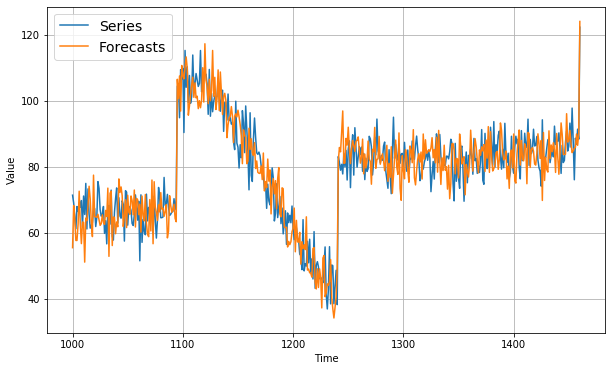

In [24]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

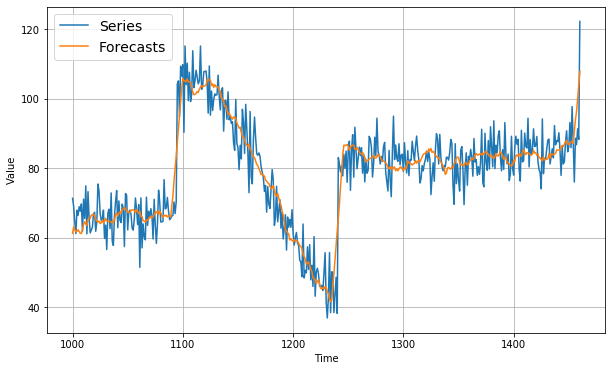

In [27]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(
    series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid,
                                  diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772

# 创建窗口数据

In [29]:
def window_dataset(series, window_size, batch_size=32, shuffle_bluffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_bluffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [34]:
tmp = tf.range(10)
tmp_dataset = window_dataset(tmp.numpy(), window_size=5, batch_size=2)
for d, l in tmp_dataset.take(2):
    print(d.numpy(), l.numpy())

[[2 3 4 5 6]
 [0 1 2 3 4]] [7 5]
[[3 4 5 6 7]
 [1 2 3 4 5]] [8 6]


# 机器学习模型

In [35]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## 线性模型

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

# 线性模型
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(1, input_shape=[window_size])])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae'],
)

model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 19ms/step - loss: 46.5854 - mae: 47.9542 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 11.8285 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 10.1682 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 9.8548 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 9.3782 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 9.5393 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 9.4518 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/100
31/31 [==============================] - 0s 3ms/step 

Epoch 63/100
31/31 [==============================] - 0s 3ms/step - loss: 5.8499 - mae: 6.2962 - val_loss: 6.0042 - val_mae: 6.3899
Epoch 64/100
31/31 [==============================] - 0s 3ms/step - loss: 5.9194 - mae: 6.2138 - val_loss: 5.8279 - val_mae: 6.3414
Epoch 65/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6132 - mae: 6.2228 - val_loss: 5.7855 - val_mae: 6.2484
Epoch 66/100
31/31 [==============================] - 0s 3ms/step - loss: 5.5265 - mae: 6.1685 - val_loss: 5.7921 - val_mae: 6.2485
Epoch 67/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6643 - mae: 6.1712 - val_loss: 5.8200 - val_mae: 6.2940
Epoch 68/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7893 - mae: 6.1653 - val_loss: 5.7905 - val_mae: 6.2627
Epoch 69/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7449 - mae: 6.1001 - val_loss: 5.8544 - val_mae: 6.3617
Epoch 70/100
31/31 [==============================] - 0s 3ms/step - loss: 5.

In [45]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(1, input_shape=[window_size])])

# 线性模型 + 学习率规划 --> 选择最优的学习率
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**
                                                    (epoch / 30))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 9ms/step - loss: 60.3959 - mae: 61.1013
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 45.2095 - mae: 45.6320
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 27.4542 - mae: 27.8690
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 11.8220 - mae: 12.2636
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.3539 - mae: 8.8524
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 8.3123 - mae: 8.7969
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 8.3018 - mae: 8.7610
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 8.2751 - mae: 8.7517
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 8.2521 - mae: 8.7435
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 8.2475 - mae: 8.7350
Epoch 11/100
31/31 [==============================]

31/31 [==============================] - 0s 2ms/step - loss: 22.9690 - mae: 23.6475
Epoch 88/100
31/31 [==============================] - 0s 2ms/step - loss: 34.1135 - mae: 34.6069
Epoch 89/100
31/31 [==============================] - 0s 2ms/step - loss: 33.0733 - mae: 33.8601
Epoch 90/100
31/31 [==============================] - 0s 2ms/step - loss: 64.3620 - mae: 64.6561
Epoch 91/100
31/31 [==============================] - 0s 2ms/step - loss: 41.5368 - mae: 42.8897
Epoch 92/100
31/31 [==============================] - 0s 2ms/step - loss: 48.8983 - mae: 49.7774
Epoch 93/100
31/31 [==============================] - 0s 2ms/step - loss: 95.0609 - mae: 96.7020
Epoch 94/100
31/31 [==============================] - 0s 2ms/step - loss: 83.6038 - mae: 84.3416
Epoch 95/100
31/31 [==============================] - 0s 2ms/step - loss: 61.1714 - mae: 61.3968
Epoch 96/100
31/31 [==============================] - 0s 2ms/step - loss: 141.8529 - mae: 142.0487
Epoch 97/100
31/31 [=====================

[1e-06, 0.001, 0, 20]

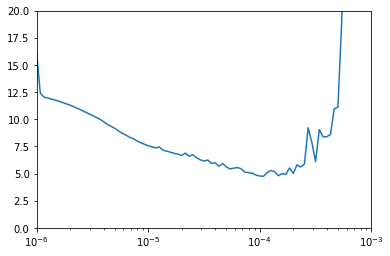

In [43]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])
# 学习率10^-6时损失较大，10^-4以后损失开始出现波动，因此保险选择学习率 10^-5

In [46]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(1, input_shape=[window_size])])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# 早停机制，连续 10 epochs，结果无改善，就停止训练
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set,
          epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 9ms/step - loss: 14.8029 - mae: 15.4354 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 11.0106 - mae: 11.3735 - val_loss: 10.7544 - val_mae: 11.3689
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 10.2586 - mae: 10.9062 - val_loss: 9.6834 - val_mae: 10.0524
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 10.3236 - mae: 10.7052 - val_loss: 9.2161 - val_mae: 9.6932
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 9.8594 - mae: 10.3972 - val_loss: 10.4635 - val_mae: 11.0643
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 9.5503 - mae: 10.1716 - val_loss: 8.9184 - val_mae: 9.4712
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 9.2501 - mae: 9.9396 - val_loss: 8.7987 - val_mae: 9.3669
Epoch 8/500
31/31 [==============================] - 0s 3ms/

Epoch 63/500
31/31 [==============================] - 0s 3ms/step - loss: 5.3993 - mae: 5.9240 - val_loss: 5.4518 - val_mae: 6.0181
Epoch 64/500
31/31 [==============================] - 0s 3ms/step - loss: 5.4773 - mae: 5.8977 - val_loss: 5.6426 - val_mae: 6.1303
Epoch 65/500
31/31 [==============================] - 0s 3ms/step - loss: 5.2755 - mae: 5.8501 - val_loss: 5.4385 - val_mae: 5.9496
Epoch 66/500
31/31 [==============================] - 0s 3ms/step - loss: 5.2938 - mae: 5.8049 - val_loss: 5.7750 - val_mae: 6.2817
Epoch 67/500
31/31 [==============================] - 0s 3ms/step - loss: 5.3725 - mae: 5.8361 - val_loss: 5.4742 - val_mae: 5.9062
Epoch 68/500
31/31 [==============================] - 0s 3ms/step - loss: 5.3134 - mae: 5.7848 - val_loss: 5.4017 - val_mae: 5.9286
Epoch 69/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1383 - mae: 5.7416 - val_loss: 5.4241 - val_mae: 5.8637
Epoch 70/500
31/31 [==============================] - 0s 3ms/step - loss: 5.

(461,)


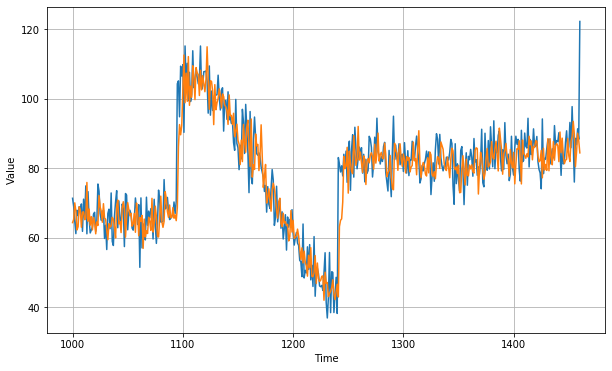

In [48]:
# 模型进行预测


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


lin_forecast = model_forecast(model, series[split_time - window_size:-1],
                              window_size)[:, 0]
print(lin_forecast.shape)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [49]:
# 模型性能
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.288254

## 模型预测

Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 43.7540 - mae: 44.3312
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.3574 - mae: 42.0073
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.5907 - mae: 39.1402
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 35.2973 - mae: 35.8227
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 31.6483 - mae: 32.0831
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 27.4519 - mae: 27.9021
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.8110 - mae: 23.2716
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 17.8342 - mae: 18.2723
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 12.6880 - mae: 13.1545
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5515 - mae: 9.0650
Epoch 11/100
31/31 [=====================

31/31 [==============================] - 0s 2ms/step - loss: 37.7639 - mae: 38.2556
Epoch 88/100
31/31 [==============================] - 0s 2ms/step - loss: 41.1958 - mae: 41.7623
Epoch 89/100
31/31 [==============================] - 0s 2ms/step - loss: 40.2291 - mae: 40.7723
Epoch 90/100
31/31 [==============================] - 0s 2ms/step - loss: 39.2912 - mae: 39.7405
Epoch 91/100
31/31 [==============================] - 0s 2ms/step - loss: 37.4291 - mae: 38.0289
Epoch 92/100
31/31 [==============================] - 0s 2ms/step - loss: 31.9095 - mae: 32.4189
Epoch 93/100
31/31 [==============================] - 0s 2ms/step - loss: 18.4593 - mae: 18.8675
Epoch 94/100
31/31 [==============================] - 0s 2ms/step - loss: 15.7180 - mae: 16.2250
Epoch 95/100
31/31 [==============================] - 0s 2ms/step - loss: 15.1604 - mae: 15.6424
Epoch 96/100
31/31 [==============================] - 0s 2ms/step - loss: 15.7109 - mae: 16.2041
Epoch 97/100
31/31 [=======================

[1e-07, 0.005, 0, 30]

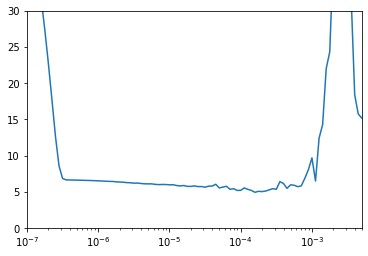

In [52]:
tf.keras.backend.clear_session() # 统一单元重复使用，清除

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])



[1e-07, 0.005, 0, 30]

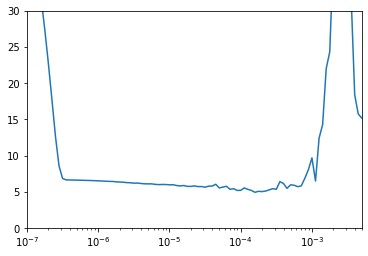

In [53]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 5e-3, 0, 30])

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# 早停机制
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set,
          epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 11ms/step - loss: 49.0113 - mae: 50.1237 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 21.3516 - mae: 18.9391 - val_loss: 7.2486 - val_mae: 7.6752
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 8.5335 - mae: 8.8841 - val_loss: 8.3660 - val_mae: 8.8643
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 7.6887 - mae: 8.2310 - val_loss: 7.1901 - val_mae: 7.7065
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 7.4371 - mae: 8.1041 - val_loss: 7.6501 - val_mae: 8.0162
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 7.5916 - mae: 8.0378 - val_loss: 7.3224 - val_mae: 7.8764
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 7.2528 - mae: 7.8786 - val_loss: 7.2493 - val_mae: 7.5234
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - los

31/31 [==============================] - 0s 3ms/step - loss: 5.1458 - mae: 5.6038 - val_loss: 5.1624 - val_mae: 5.6328
Epoch 64/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1517 - mae: 5.5608 - val_loss: 5.0926 - val_mae: 5.5706
Epoch 65/500
31/31 [==============================] - 0s 3ms/step - loss: 5.1298 - mae: 5.5578 - val_loss: 5.1319 - val_mae: 5.5076


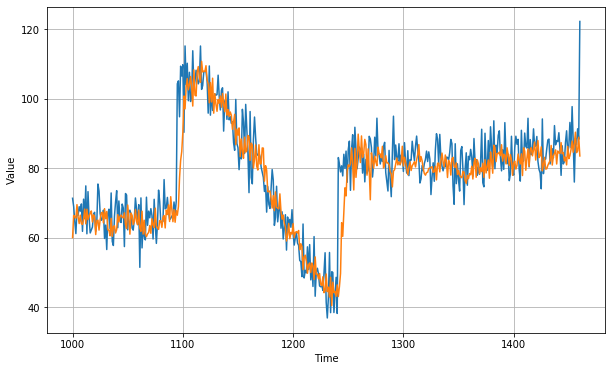

In [55]:
dense_forecast = model_forecast(model, series[split_time - window_size:-1],
                                window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)